In [49]:
import os
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import polars as pl
from warnings import simplefilter
import time
simplefilter('ignore')
%matplotlib inline

In [50]:
start = time.time()
df = pl.read_csv('/work/InternalMedicine/s223850/ED-StaticDynamic/raw_data/ED Events - 12.21.23.csv',
                 infer_schema_length=int(5e6),
                 null_values=dict(Patient_Age='NULL'),
                 dtypes=dict(Patient_Age=pl.Float64)
                )
# dff = df.to_pandas()
print(f'Took polars to pandas:{time.time()-start} seconds')

Took polars to pandas:12.707985401153564 seconds


In [7]:
start = time.time()
df = pd.read_csv('/work/InternalMedicine/s223850/ED-StaticDynamic/raw_data/ED Events - 12.21.23.csv')
print(f'Took polars to pandas:{time.time()-start} seconds')

Took polars to pandas:54.40079712867737 seconds


# Functions to refactor

In [1]:
def exclude_admit_flags_prior_to_admission(df, admi_flags, pat_id, target_col, datecol, event_col):
    admi_flags_times = defaultdict(list) # in minutes
    df_admi = df[df[target_col]=='Admitted']
    group_admi = df_admi.groupby(pat_id)

    for grb, df_grb in group_admi:
        admi_mask = df_grb[event_col].isin(admi_flags)

        if admi_mask.sum() == 0:
            continue

        mask_admission = df_grb['Type'] == 'Order - Admission'
        if mask_admission.sum() > 0:
            admi_time = df_grb.iloc[np.where(mask_admission)[0][0]][datecol]
            for idx, row in df_grb[admi_mask].iterrows():
                admi_flags_times[row[event_col]].append(('admission', grb, (admi_time-row[datecol]).total_seconds()/60))
    
    
    flag_time_dict = defaultdict(list)
    for flag, data_list in admi_flags_times.items():
        for d in data_list:
            flag_time_dict[flag].append(d[-1])
    
    return list(map(lambda x: x[0], list(filter(lambda x: np.median(x[1])<=0, flag_time_dict.items()))))

In [2]:
def get_target_flags(raw_file_path, event_col='EVENT_NAME', grb_col='Admitted_YN', flag='admi', normalize_text=True, corr_threshold=0.7):
    if isinstance(raw_file_path, str):
        df_raw = pd.read_csv(raw_file_path)
    else:
        df_raw = raw_file_path
    if normalize_text:
        df_raw[f'{event_col}_NORM'] = df_raw[event_col].apply(lambda x: re.sub(r'[^a-zA-Z0-9_]', '', x)).str.lower()
        event_col = f'{event_col}_NORM'

    flag_df = df_raw.loc[df_raw[event_col].str.lower().str.contains(flag), [event_col, grb_col]]
    flag_grb = flag_df.groupby(grb_col).value_counts()

    data = pd.DataFrame(0, index=flag_df[event_col].unique(), columns=flag_df[grb_col].unique())
    for (flag, event), value in flag_grb.items():
        data.loc[event, flag] = value
    
    data['total'] = data.sum(axis=1)
    # TODO: This is a hardcoded value of the target params and need to be changed manually
    data['perc_pos'] = data['Admitted']/data['total']

    target_events = data.loc[(data['perc_pos']>=corr_threshold)|(data['perc_pos']<=(1-corr_threshold))].index
    return target_events, data


In [3]:
def get_all_target_flags(raw_data_path, event_col, target_col, normalize_text, corr_thr, datecol='Calculated_DateTime', pat_id='PAT_ENC_CSN_ID'):
    if isinstance(raw_data_path, str):
        df = pd.read_csv(raw_data_path)
    else:
        df = raw_data_path
    df['Calculated_DateTime'] = pd.to_datetime(df['Calculated_DateTime'])
    df = df.sort_values(by='Calculated_DateTime')

    admi_flags, admi_data  = get_target_flags(df, event_col, target_col, 'admi', normalize_text, corr_thr)
    admi_flags = exclude_admit_flags_prior_to_admission(df, admi_flags, pat_id, target_col, datecol, event_col if not normalize_text else f'{event_col}_NORM')

    bed_flags, bed_data   = get_target_flags(df, event_col, target_col, 'bed', normalize_text, corr_thr)
    bed_flags = exclude_admit_flags_prior_to_admission(df, bed_flags, pat_id, target_col, datecol, event_col if not normalize_text else f'{event_col}_NORM')

    disch_flags, dishc_data = get_target_flags(df, event_col, target_col, 'disch', normalize_text, corr_thr)

    consu_flags, consu_data = get_target_flags(df, event_col, target_col, 'consu', normalize_text, corr_thr)
    consu_flags = exclude_admit_flags_prior_to_admission(df, consu_flags, pat_id, target_col, datecol, event_col if not normalize_text else f'{event_col}_NORM')

    obser_flags, obser_data = get_target_flags(df, event_col, target_col, 'observ', normalize_text, corr_thr)
    obser_flags = exclude_admit_flags_prior_to_admission(df, obser_flags, pat_id, target_col, datecol, event_col if not normalize_text else f'{event_col}_NORM')
    all_flags = np.concatenate([admi_flags, bed_flags, disch_flags, consu_flags, obser_flags])
    all_flags_list = list(set(all_flags))
    return all_flags_list

In [4]:
def set_admitted_discharged_only(df, target_col, admit_val, val2del, dropna=True):
    if dropna:
        print('Removing nans in the label if exists ...')
        print(f'There are {df[target_col].isna().sum()} target nan values ...')
        print(f'Size before removing nans: {df.shape} ...')
        df = df[~df[target_col].isna()]
        print(f'Size after removing nans: {df.shape} ...')

    if len(val2del) > 0:
        print(f"Target values to be excluded {val2del}")
        print(f'Size before removing {val2del}: {df.shape} ...')
        df = df.loc[~(df[target_col].isin(val2del))]
        print(f'Size after removing {val2del}: {df.shape} ...')

    df.loc[df[target_col]!=admit_val, target_col] = 'NotAdmitted'
    return df

In [5]:
def process_raw_data(raw_data, output_path, noflags, writedata=False):
        df = pd.read_csv(raw_data)
        subdir_name = os.path.basename(raw_data).split('-')[-1].strip().split('.csv')[0].replace('.','_')
        output_dir = Path(output_path) / Path(subdir_name)
        output_dir.mkdir(parents=True, exist_ok=True)

        vals2del = [val for val in df['ED_Disposition'].unique() if val not in ['Admitted', 'Discharged']]
        df = set_admitted_discharged_only(df, 'ED_Disposition', 'Admitted', vals2del)
        if not noflags:
            all_flags_list = get_all_target_flags(df, 'EVENT_NAME', 'ED_Disposition', True, 1.0)
            # df_clean_list, error_list, orderbflag_list = clean_target(raw_data, all_flags_list, 'EVENT_NAME', 'PAT_ENC_CSN_ID', 'Calculated_DateTime', 'Type', 'Arrived_Time', True)
            df_clean_list, error_list, orderbflag_list = clean_target_withnoterminationflags(df, all_flags_list, 'EVENT_NAME', 'PAT_ENC_CSN_ID', 'Calculated_DateTime', 'Type', 'Arrived_Time', True, min_date=pd.Timestamp(year=2021, month=1, day=1))
            df_clean = pd.concat(df_clean_list)
        else:
            df_clean=df
            error_list=[]
            orderbflag_list=[]

        if writedata:
            df_clean.to_csv(os.path.join(output_dir, 'df_clean.csv'))
            with open(os.path.join(output_dir, 'error_list.joblib'), 'wb') as f:
                joblib.dump(error_list, f)
            with open(os.path.join(output_dir, 'orderbflag.joblib'), 'wb') as f:
                joblib.dump(orderbflag_list, f)

        return df_clean, error_list, orderbflag_list, output_dir

# Refactoring draft

### Cleaning target variable `set_admitted_discharged_only`

In [51]:
df = df.filter((pl.col('ED_Disposition')=='Admitted')|(pl.col('ED_Disposition')=='Discharged'))
df = df.with_columns([
    pl.col('Arrived_Time').str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S%.f"),
    pl.col('Calculated_DateTime').str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S%.f")
])
df = df.sort(by='Calculated_DateTime')

In [52]:
df = df.with_columns([
    (pl.col('Calculated_DateTime')-pl.col('Arrived_Time')).dt.total_minutes().alias('elapsed_time_min')
])

In [ ]:
ppv = 0.45

In [57]:
t = time.time()

# Step 1: Determine the last 'ED_Disposition' per group
last_disposition = df.select([
    pl.col("ED_Disposition"),
    pl.col("PAT_ENC_CSN_ID")
]).sort("ED_Disposition", reverse=True).groupby("PAT_ENC_CSN_ID").agg(pl.first("ED_Disposition").alias("last_disposition"))

# Step 2: Determine the sum of 'Order - Admission' per group
order_admission_count = df.filter(pl.col("Type") == "Order - Admission").groupby("PAT_ENC_CSN_ID").agg(pl.count("Type").alias("order_admission_count"))

# Join these summaries back to the original DataFrame
df = df.join(last_disposition, on="PAT_ENC_CSN_ID", how="left")
df = df.join(order_admission_count, on="PAT_ENC_CSN_ID", how="left").fillna({"order_admission_count": 0})

# Step 3: Add a flag based on conditions
df = df.with_columns(
    ((pl.col("last_disposition") == "Admitted") & (pl.col("order_admission_count") == 0)).alias("remove_group")
)

# Filter out the rows based on the flag
df_exclude_admit_with_no_order = df.filter(~pl.col("remove_group"))

# Optionally drop the helper columns and flag
df_exclude_admit_with_no_order = df_exclude_admit_with_no_order.drop(["last_disposition", "order_admission_count", "remove_group"])


# Step 4: Optionally drop helper columns if they are not needed further
df_exclude_admit_with_no_order1 = df_exclude_admit_with_no_order1.drop(['last_disposition', 'order_admission_count'])
print(time.time()-t)

1.1067209243774414


In [36]:
t = time.time()
df_exclude_admit_with_no_order = df.group_by('PAT_ENC_CSN_ID').apply(lambda df_group: pl.DataFrame({c: [] for c in df.columns}) if (df_group['ED_Disposition'][-1]=='Admitted') and (df_group['Type']=='Order - Admission').sum()==0 else df_group  )
print(time.time()-t)

18.308658599853516


In [38]:
df_exclude_admit_with_no_order = df_exclude_admit_with_no_order.drop(['last_disposition', 'order_admission_count'])

In [58]:
len(df_exclude_admit_with_no_order.columns), len(df_exclude_admit_with_no_order1.columns)

(32, 32)

In [59]:
set(df_exclude_admit_with_no_order.columns)-set(df_exclude_admit_with_no_order1.columns)

set()

In [60]:
df_exclude_admit_with_no_order1['PAT_ENC_CSN_ID'].n_unique(), df_exclude_admit_with_no_order['PAT_ENC_CSN_ID'].n_unique()

(108248, 107939)

In [61]:
mismatch_pat_id= set(df_exclude_admit_with_no_order1['PAT_ENC_CSN_ID'].unique())-set(df_exclude_admit_with_no_order['PAT_ENC_CSN_ID'].unique())

In [62]:
len(mismatch_pat_id)

309

In [56]:
df.filter(pl.col('PAT_ENC_CSN_ID')==list(mismatch_pat_id)[0])['Type'].value_counts()

Type,count
str,u32
"""Order - Medica…",3
"""Order - Consul…",1
"""Order - Nursin…",1
"""Order - Imagin…",2
"""Lab Order - Re…",52
"""Event""",56
"""Order - Lab""",16


In [11]:
def process_group(df_group):
    if df_group['ED_Disposition'][-1] == 'Admitted' and\
    df_group.filter(pl.col('Type') == 'Order - Admission').shape[0] == 0:
        return pl.DataFrame(columns=df_group.columns)
    if (df_group.filter(pl.col('Type') == 'Order - Admission').shape[0] == 0) and\
        (df_group.filter(pl.col('Type') == 'Order - Discharge').shape[0] == 0):
        return df_group
    for idx, row in enumerate(df_group.rows()):
        if row['Type'] == 'Order - Admission':
            return df_group.slice(0, idx+1)
        elif row['Type'] == 'Order - Discharge':
            return df_group.slice(0, idx+1)
            
    return df_group

In [12]:
df_preproc = df.group_by('PAT_ENC_CSN_ID').apply(process_group)

thread 'python' panicked at py-polars/src/dataframe/general.rs:355:31:
UDF failed: tuple indices must be integers or slices, not str


PanicException: UDF failed: tuple indices must be integers or slices, not str

In [68]:
g = df.filter(pl.col('ED_Disposition')=='Admitted').group_by('PAT_ENC_CSN_ID')

In [70]:
d_s = next(iter(g))

In [37]:
total_pats = df['PAT_ENC_CSN_ID'].unique()

In [33]:
df.shape, df['PAT_ENC_CSN_ID'].n_unique()

((17305131, 32), 125732)

In [35]:
df.filter( (pl.col('elapsed_time_min')>0)&(pl.col('elapsed_time_min')<1475))['PAT_ENC_CSN_ID'].n_unique()

123188

In [47]:
# Excluded patients due to length of stay in ED (negative and too long)
neg_pats = df.filter(pl.col('elapsed_time_min')<0)['PAT_ENC_CSN_ID'].unique()

In [43]:
outlier_val = np.percentile(df.filter(pl.col('elapsed_time_min')>0).select('elapsed_time_min').to_numpy(), 99.5)
too_long_pats = df.filter((pl.col('elapsed_time_min')>0)&(pl.col('elapsed_time_min')<outlier_val))['PAT_ENC_CSN_ID'].unique()

In [41]:
patients_with_negative_elapsed_time = np.setdiff1d(total_pats, too_long)

In [48]:
neg_pats.to_pandas().to_csv('patients_with_negative_elapsed_time.csv')

In [29]:
neg_pats.to_pandas().to_csv('patients_with_negative_elapsed_time.csv')

1475.0

<Axes: >

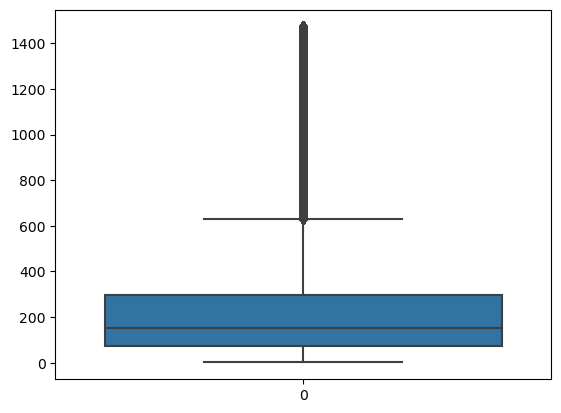

In [31]:
sns.boxplot().select('elapsed_time_min').to_numpy())